In [ ]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

### **Reading the CSV File**

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Stock Market Prediction using Numerical and Textual Analysis/india-news-headlines.csv')[:2000000]
data.head()

,publish_date,headline_category,headline_text
0,20010101,sports.wwe,win over cena satisfying but defeating underta...
1,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
2,20010102,unknown,Fissures in Hurriyat over Pak visit
3,20010102,unknown,America's unwanted heading for India?
4,20010102,unknown,For bigwigs; it is destination Goa


### **Shape of the data**

In [ ]:
data.shape

(2000000, 3)

### **Number of unique headline_category fields**

In [ ]:
len(data['headline_category'].unique())

1016

### **Checking for null values**

In [ ]:
data.isnull().sum()

publish_date         0
headline_category    0
headline_text        0
dtype: int64

### **Pre-Processing the data**

In [ ]:
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    
    phrase = re.sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", phrase)
    phrase = re.sub(r"\+", " plus ", phrase)
    phrase = re.sub(r",", " ", phrase)
    phrase = re.sub(r"\.", " ", phrase)
    phrase = re.sub(r"!", " ! ", phrase)
    phrase = re.sub(r"\?", " ? ", phrase)
    phrase = re.sub(r"'", " ", phrase)
    phrase = re.sub(r":", " : ", phrase)
    phrase = re.sub(r"\s{2,}", " ", phrase)
    return phrase

In [ ]:
import nltk
nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
from tqdm import tqdm
from bs4 import BeautifulSoup
import re
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(data['headline_text'].astype(str)):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 2000000/2000000 [08:15<00:00, 4035.42it/s]


In [ ]:
preprocessed_reviews[:5]

['win cena satisfying defeating undertaker bigger roman reigns',
 'status quo disturbed ayodhya says vajpayee',
 'fissures hurriyat pak visit',
 'america unwanted heading india',
 'bigwigs destination goa']

### **Using gensim word_to_vec**

In [ ]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [ ]:
X_train=np.array(preprocessed_reviews)
X_train.shape

(2000000,)

### **Avg W2V Vectorization**

In [ ]:
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
w2v_words = list(w2v_model.wv.vocab)
sent_vectors_train = []; 
for sent in tqdm(list_of_sentance_train):  
    sent_vec = np.zeros(50) 
    cnt_words =0;
    for word in sent: 
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words 
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

100%|██████████| 2000000/2000000 [29:22<00:00, 1134.82it/s]

2000000
50


In [ ]:
len(sent_vectors_train)

2000000

In [ ]:
pickle.dump(sent_vectors_train, open("/content/drive/MyDrive/Stock Market Prediction using Numerical and Textual Analysis/sent_vectors_train.pickel", "wb"))

### **Using the KMeans Algorithm**


In [ ]:
k = KMeans(n_clusters = 2,random_state=True)
model = k.fit(sent_vectors_train)

In [ ]:
cluster1,cluster2 = [],[]
for i in range(model.labels_.shape[0]):
    if model.labels_[i] == 0:
        cluster1.append(preprocessed_reviews[i])
    elif model.labels_[i] == 1:
        cluster2.append(preprocessed_reviews[i])

In [ ]:
'''model = KMeans(n_clusters=2, max_iter=1000, random_state=True, n_init=50).fit(X=sent_vectors_train)
positive_cluster_center = model.cluster_centers_[0]
negative_cluster_center = model.cluster_centers_[1]'''

### **Cluster centres of Neagtive and Positive Cluster**

In [ ]:
model.cluster_centers_

array([[-0.23663581, -0.23119801, -0.32709142, -0.77183465,  0.12972905,
         0.40085287, -0.24506957, -0.78085005, -0.2597947 ,  0.74203939,
        -0.63441455, -1.0111763 ,  0.22764269,  0.97357028,  0.09311394,
        -0.05537859,  0.22623744,  0.09818939,  0.18458073,  0.03373211,
        -0.08995045,  0.57907514, -0.58275081,  0.04443284, -0.31710443,
        -0.50926047, -0.4905131 , -1.00564802,  0.15531424, -0.40990182,
         0.30979648,  0.04389773, -0.77680056, -0.75739555, -0.34932272,
        -0.3075814 ,  0.00964388,  0.42683792, -0.38977764,  0.29453108,
        -0.03345759, -0.44684241,  0.10752848, -0.35404535, -0.45735275,
        -0.07082973,  0.93995322, -0.33010729,  0.33986304,  0.28752716],
       [-0.13059151, -0.03696827,  0.26093963, -0.34974392,  0.07160384,
         0.21196791,  0.2137289 , -0.50438986, -0.02419257, -0.35479173,
         0.08212975, -0.37124619,  0.15625133,  0.14147392,  0.28574542,
        -0.77368703, -0.0550911 , -0.12782143, -0.

In [ ]:
w2v_model.similar_by_vector(model.cluster_centers_[0], topn=15, restrict_vocab=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('sdo', 0.750637412071228),
 ('bdo', 0.7229923605918884),
 ('minor', 0.7222123146057129),
 ('viquar', 0.7201690077781677),
 ('shopowner', 0.7189401388168335),
 ('kandivli', 0.7187928557395935),
 ('trespass', 0.7179482579231262),
 ('accused', 0.7177493572235107),
 ('bara', 0.7167806029319763),
 ('sho', 0.7143116593360901),
 ('landlord', 0.7121511697769165),
 ('kidnappers', 0.7106489539146423),
 ('khandwa', 0.7089946269989014),
 ('dacoity', 0.7042157053947449),
 ('molester', 0.7029110789299011)]

In [ ]:
w2v_model.similar_by_vector(model.cluster_centers_[1], topn=15, restrict_vocab=None)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  """Entry point for launching an IPython kernel.


[('ttl', 0.7318345904350281),
 ('scania', 0.7243543863296509),
 ('msmes', 0.7157934904098511),
 ('amfi', 0.7052112817764282),
 ('vsp', 0.6987445950508118),
 ('papanasam', 0.6967921853065491),
 ('rejections', 0.6957463622093201),
 ('oppi', 0.6945763230323792),
 ('iimb', 0.6931653618812561),
 ('sda', 0.6884422898292542),
 ('proportionate', 0.6881464123725891),
 ('childcare', 0.6878477334976196),
 ('naysayers', 0.6844684481620789),
 ('fsa', 0.683925986289978),
 ('weeded', 0.6805171966552734)]

**We can see that the cluster 1 has negative words and cluster 2 has positive words.**

### **Words Visualization in the Negative News Headlines**

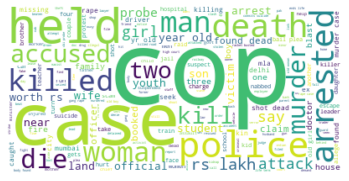

In [ ]:
data=''
for i in cluster1:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### **Words Visualization in the Positive News Headlines**


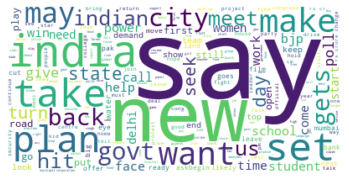

In [ ]:
data=''
for i in cluster2:
    data+=str(i)
from wordcloud import WordCloud
wordcloud = WordCloud(background_color="white").generate(data)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### **Count of Positive and Negtive News Headlines**

In [ ]:
print("The prediction of number of negative news headlines in the dataset is:", len(cluster1))
print("The prediction of number of positive news headlines in the dataset is:", len(cluster2))

The prediction of number of negative news headlines in the dataset is: 411803
The prediction of number of positive news headlines in the dataset is: 1588197


### **Some Negative News Headlines in the dataset**

In [ ]:
cluster1[:25]

['gilani claims applied passport years ago',
 'official sued briber',
 'gilani claims applied passport years ago',
 'official sued briber',
 'bomb hoax triggers panic canara bank',
 'petition ministers assets dismissed',
 'beat polio truck driver life',
 'auto driver murder held',
 'murder spoils party dharwad',
 'petrol pump sealed selling adulterated fuel',
 'year old girl missing',
 'power row bribe attempt charge denied',
 'child project officer held fraud',
 'milosevic charged abuse office',
 'court reserves judgment custody ilyasi daughter',
 'cholera outbreak source traced',
 'bangladesh iscrutinising citizen death us embassy',
 'milosevic charged abuse office',
 'court reserves judgment custody ilyasi daughter',
 'court reserves judgment custody ilyasi daughter',
 'cholera outbreak source traced',
 'milosevic charged abuse office',
 'court reserves judgment custody ilyasi daughter',
 'four iranians admit role serial murders',
 'cholera outbreak source traced']

### **Some Positive News Headlines in the dataset**

In [ ]:
cluster2[:25]

['win cena satisfying defeating undertaker bigger roman reigns',
 'status quo disturbed ayodhya says vajpayee',
 'fissures hurriyat pak visit',
 'america unwanted heading india',
 'bigwigs destination goa',
 'extra buses clear tourist traffic',
 'dilute power transfers says riberio',
 'focus shifts teaching hindi',
 'become compulsory schools',
 'move stop freedom fighters pension flayed',
 'parivar dismisses pm warning',
 'india pak exchange lists n plants',
 'qureshi return really help govt',
 'pm tacit message put ram tample hold',
 'text prime minister article',
 'ncw focus violence women',
 'bbc reality tv focus aiims',
 'jaitley firm legal reforms',
 'hoshangabad farmers enough water',
 'bjp jumps rail track conversion issue',
 'america unwanted heading india',
 'state may take ap court krishna',
 'park turns temple compound residents watch',
 'moves afoot evict squatters urban dist',
 'mafia calls shots gandhinagar']